# Querying and joining all of the data

Here we want to check what is the adequate timeframe to wait for a patent to be granted. (After the search report has been published).

This will be checked on a general and per industry basis to determine what is a "good" interval for  a patent to be granted. (Because we do not have acess to the decission data).

In [4]:
from epo.tipdata.epab import EPABClient
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
epab = EPABClient('PROD')

In [3]:
epab.fields()

WidDatabaseFields(header='', input_data={'': [{'name': 'epab_doc_id', 'type': 'STRING', 'mode': 'REQUIRED', 'd…

We need to combine the A1 publications with the A2 and A3 

In [92]:
# I am using the following code to query the EPO full text database: #Here we select all of the A1 publications

# Defining the fields to select
selection = (
    "a.publication,"
    "a.application,"
    "a.ipc,"
    "a.cpc,"
    "MIN(b.publication.date) AS patent_granted_date,"    
    "CASE WHEN MIN(b.publication.date) IS NOT NULL THEN TRUE ELSE FALSE END AS patent_granted"
)

condition = (
    " WHERE a.publication.kind LIKE 'A1'"
    " AND a.search_report IS NOT NULL"
)

# Putting the statement together
statement = (
    f"SELECT {selection} "
    f"FROM `{epab.full_table_name}` AS a "
    f"LEFT JOIN `{epab.full_table_name}` AS b "
    f"ON a.application.number = b.application.number "
    f"AND b.publication.kind LIKE 'B1' "
    f"{condition} "
    # Group by your dimension fields (not by the new aggregates)
    f"GROUP BY "
    f"  a.publication,"
    f"a.ipc,"
    f"a.cpc,"
    f"  a.application;"
)

print(statement)

# Querying EPAB with the SQL statement
A1_publications = epab.sql_query(statement)

SELECT a.publication,a.application,a.ipc,a.cpc,MIN(b.publication.date) AS patent_granted_date,CASE WHEN MIN(b.publication.date) IS NOT NULL THEN TRUE ELSE FALSE END AS patent_granted FROM `p-epo-tip-prj-3a1f.p_epo_tip_euwe4_bqd_epab.publications` AS a LEFT JOIN `p-epo-tip-prj-3a1f.p_epo_tip_euwe4_bqd_epab.publications` AS b ON a.application.number = b.application.number AND b.publication.kind LIKE 'B1'  WHERE a.publication.kind LIKE 'A1' AND a.search_report IS NOT NULL GROUP BY   a.publication,a.ipc,a.cpc,  a.application;


In [124]:
tally_dict = tally_list_lengths(A1_publications,'ipc')

In [110]:
#Here we select all of the A2 publications

# Defining the fields to select
selection = (
    "MIN(a.publication.date) AS earliest_A2_publication_date,"
    "a.application,"
    "a.ipc,"
    "a.cpc,"
    "MIN(b.publication.date) AS patent_granted_date, "    
    "CASE WHEN MIN(b.publication.date) IS NOT NULL THEN TRUE ELSE FALSE END AS patent_granted"
)

# Defining the condition: publications with a non-null publication date
condition = (
    " WHERE a.publication.kind LIKE 'A2%'"
)

# Putting the statement together
statement = (
     f"SELECT {selection} "
    f"FROM `{epab.full_table_name}` AS a "
    f"LEFT JOIN `{epab.full_table_name}` AS b "
    f"ON a.application.number = b.application.number "
    f"AND b.publication.kind LIKE 'B1' "
    f"{condition} "
    # Group by your dimension fields (not by the new aggregates)
    f"GROUP BY "
    f"a.ipc,"
    f"a.cpc,"
    f"  a.application;"

)

print(statement)

# Querying EPAB with the SQL statement
A2_publications = epab.sql_query(statement)


#Here we select all of the A3 publications

# Defining the fields to select
selection = (
    "MIN(a.publication.date) AS earliest_A3_publication_date,"
    "a.ipc,"
    "a.cpc,"
    "a.application,"
    "MIN(b.publication.date) AS patent_granted_date, "    
    "CASE WHEN MIN(b.publication.date) IS NOT NULL THEN TRUE ELSE FALSE END AS patent_granted"
)

# Defining the condition: publications with a non-null publication date
condition = (
    " WHERE a.publication.kind LIKE 'A3%'"
    "AND a.search_report IS NOT NULL"
)

# Putting the statement together
statement = (
    f"SELECT {selection} "
    f"FROM `{epab.full_table_name}` AS a "
    f"LEFT JOIN `{epab.full_table_name}` AS b "
    f"ON a.application.number = b.application.number "
    f"AND b.publication.kind LIKE 'B1' "
    f"{condition} "
    # Group by your dimension fields (not by the new aggregates)
    f"GROUP BY "
    f"a.ipc,"
    f"a.cpc,"
    f"a.application;"
)

print(statement)


A3_publications =  epab.sql_query(statement)


SELECT MIN(a.publication.date) AS earliest_A2_publication_date,a.application,a.ipc,a.cpc,MIN(b.publication.date) AS patent_granted_date, CASE WHEN MIN(b.publication.date) IS NOT NULL THEN TRUE ELSE FALSE END AS patent_granted FROM `p-epo-tip-prj-3a1f.p_epo_tip_euwe4_bqd_epab.publications` AS a LEFT JOIN `p-epo-tip-prj-3a1f.p_epo_tip_euwe4_bqd_epab.publications` AS b ON a.application.number = b.application.number AND b.publication.kind LIKE 'B1'  WHERE a.publication.kind LIKE 'A2%' GROUP BY a.ipc,a.cpc,  a.application;
SELECT MIN(a.publication.date) AS earliest_A3_publication_date,a.ipc,a.cpc,a.application,MIN(b.publication.date) AS patent_granted_date, CASE WHEN MIN(b.publication.date) IS NOT NULL THEN TRUE ELSE FALSE END AS patent_granted FROM `p-epo-tip-prj-3a1f.p_epo_tip_euwe4_bqd_epab.publications` AS a LEFT JOIN `p-epo-tip-prj-3a1f.p_epo_tip_euwe4_bqd_epab.publications` AS b ON a.application.number = b.application.number AND b.publication.kind LIKE 'B1'  WHERE a.publication.kind L

In [13]:
from collections import Counter

def find_duplicate_applications(application_numbers):
    # Count occurrences of each application number
    counts = Counter(application_numbers)
    
    # Filter for duplicates (appear more than once)
    duplicates = {app: count for app, count in counts.items() if count > 1}
    
    return duplicates




In [116]:
df_A1 = pd.json_normalize(A1_publications)

df_A3 = pd.json_normalize(A3_publications)

In [126]:
to_keep = ['patent_granted_date', 'patent_granted',
       'application.number', 'application.filing_date', 'publication.date','ipc','cpc']

to_drop = [i for i in df_A1.columns if i not in to_keep]

In [127]:
df_A1.drop(columns = to_drop,inplace=True)
df_A3.rename(columns = {'earliest_A3_publication_date':'publication.date'},inplace=True)

In [128]:
pubs_with_available_search_reports_df = pd.concat([df_A1,df_A3],ignore_index=True)

In [132]:
#pubs_with_available_search_reports_df.to_csv('./Data/publications_with_available_search_reports_classification_dates_only.csv',sep='\t',index=False)

# Time to Grant distribution (all data is with search reports)

## No industry classification

In [134]:
# DATA LOADING CELL

pubs_with_available_search_reports_df = pd.read_csv('./Data/publications_with_available_search_reports_classification_dates_only.csv',sep='\t')

In [137]:
pubs_with_available_search_reports_df

,ipc,cpc,patent_granted_date,patent_granted,publication.date,application.number,application.filing_date
0,"[{'version': '8', 'symbol': 'G06Q30/02', 'cate...",[],NaN,False,20160629,14461603.4,20141222
1,"[{'version': '8', 'symbol': 'G16H50/20', 'cate...",[],NaN,False,20190821,19155430.2,20190205
2,"[{'version': '8', 'symbol': 'H01L21/66', 'cate...",[],NaN,False,20210728,21163158.5,20180209
3,"[{'version': '8', 'symbol': 'H04W72/40', 'cate...","[{'symbol': 'H04W72/40', 'category': 'Inv', 'e...",NaN,False,20230927,23160700.3,20230308
4,"[{'version': '8', 'symbol': 'G06T7/80', 'categ...","[{'symbol': 'G06T2207/30232', 'category': 'Add...",NaN,False,20220420,21210977.1,20190521
...,...,...,...,...,...,...,...
756978,"[{'version': '8', 'symbol': 'F01D5/18', 'categ...",[],20190213.0,True,20180314,12167118.4,20120508
756979,"[{'version': '8', 'symbol': 'E02D5/80', 'categ...","[{'symbol': 'E04H12/223', 'category': 'Inv', '...",20231101.0,True,20220105,21161957.2,20210311
756980,"[{'version': '8', 'symbol': 'F01D17/14', 'cate...",[],20190306.0,True,20171220,12160976.2,20120323
756981,"[{'version': '8', 'symbol': 'G05D16/10', 'cate...",[],20191127.0,True,20160601,15191477.7,20151026


In [61]:
pubs_with_available_search_reports_df =pubs_with_available_search_reports_df[pubs_with_available_search_reports_df['patent_granted']==True] 

In [138]:


pubs_with_available_search_reports_df['patent_granted_date'] = pd.to_datetime(pubs_with_available_search_reports_df['patent_granted_date'], format='%Y%m%d')
pubs_with_available_search_reports_df['publication.date'] = pd.to_datetime(pubs_with_available_search_reports_df['publication.date'], format='%Y%m%d')

# 2. Create a timedelta by subtracting dates
time_diff = pubs_with_available_search_reports_df['patent_granted_date'] - pubs_with_available_search_reports_df['publication.date']

# 3. Calculate difference in days
pubs_with_available_search_reports_df['days_to_grant'] = time_diff.dt.days  # integer

# 4. Calculate difference in months (float)
#    Option A: Approximate months by dividing days by ~30.44
pubs_with_available_search_reports_df['months_to_grant'] = pubs_with_available_search_reports_df['days_to_grant'] / 30.44
pubs_with_available_search_reports_df['years_to_grant'] = pubs_with_available_search_reports_df['months_to_grant'] / 12

pubs_with_available_search_reports_df.reset_index(drop=True, inplace=True)


In [139]:
pubs_with_available_search_reports_df

,ipc,cpc,patent_granted_date,patent_granted,publication.date,application.number,application.filing_date,days_to_grant,months_to_grant,years_to_grant
0,"[{'version': '8', 'symbol': 'G06Q30/02', 'cate...",[],NaT,False,2016-06-29,14461603.4,20141222,NaN,NaN,NaN
1,"[{'version': '8', 'symbol': 'G16H50/20', 'cate...",[],NaT,False,2019-08-21,19155430.2,20190205,NaN,NaN,NaN
2,"[{'version': '8', 'symbol': 'H01L21/66', 'cate...",[],NaT,False,2021-07-28,21163158.5,20180209,NaN,NaN,NaN
3,"[{'version': '8', 'symbol': 'H04W72/40', 'cate...","[{'symbol': 'H04W72/40', 'category': 'Inv', 'e...",NaT,False,2023-09-27,23160700.3,20230308,NaN,NaN,NaN
4,"[{'version': '8', 'symbol': 'G06T7/80', 'categ...","[{'symbol': 'G06T2207/30232', 'category': 'Add...",NaT,False,2022-04-20,21210977.1,20190521,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
756978,"[{'version': '8', 'symbol': 'F01D5/18', 'categ...",[],2019-02-13,True,2018-03-14,12167118.4,20120508,336.0,11.038108,0.919842
756979,"[{'version': '8', 'symbol': 'E02D5/80', 'categ...","[{'symbol': 'E04H12/223', 'category': 'Inv', '...",2023-11-01,True,2022-01-05,21161957.2,20210311,665.0,21.846255,1.820521
756980,"[{'version': '8', 'symbol': 'F01D17/14', 'cate...",[],2019-03-06,True,2017-12-20,12160976.2,20120323,441.0,14.487516,1.207293
756981,"[{'version': '8', 'symbol': 'G05D16/10', 'cate...",[],2019-11-27,True,2016-06-01,15191477.7,20151026,1274.0,41.852825,3.487735


<Axes: >

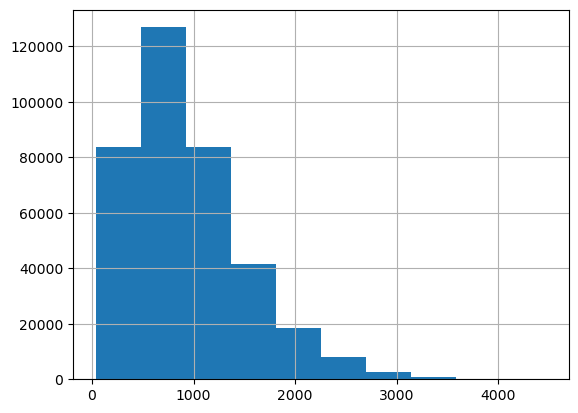

In [63]:
pubs_with_available_search_reports_df.days_to_grant.hist()

<Axes: >

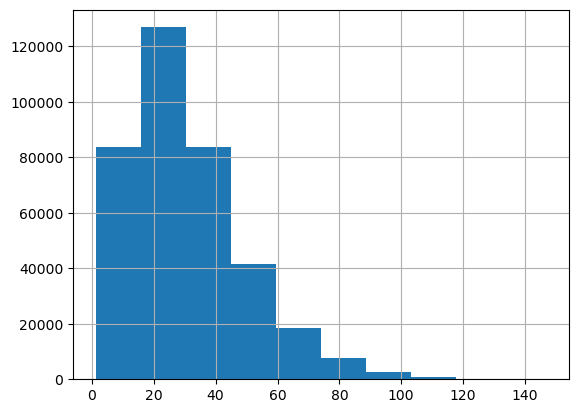

In [64]:
pubs_with_available_search_reports_df.months_to_grant.hist()

<Axes: >

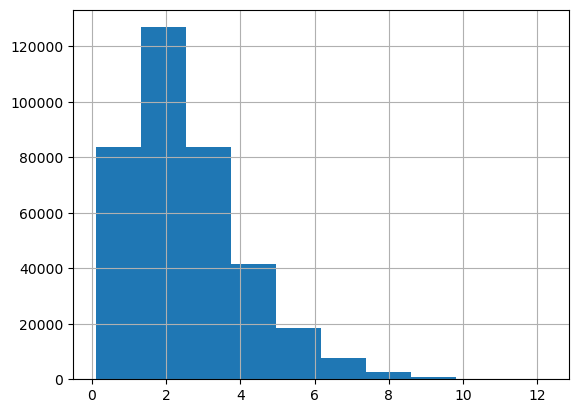

In [66]:
pubs_with_available_search_reports_df.years_to_grant.hist()

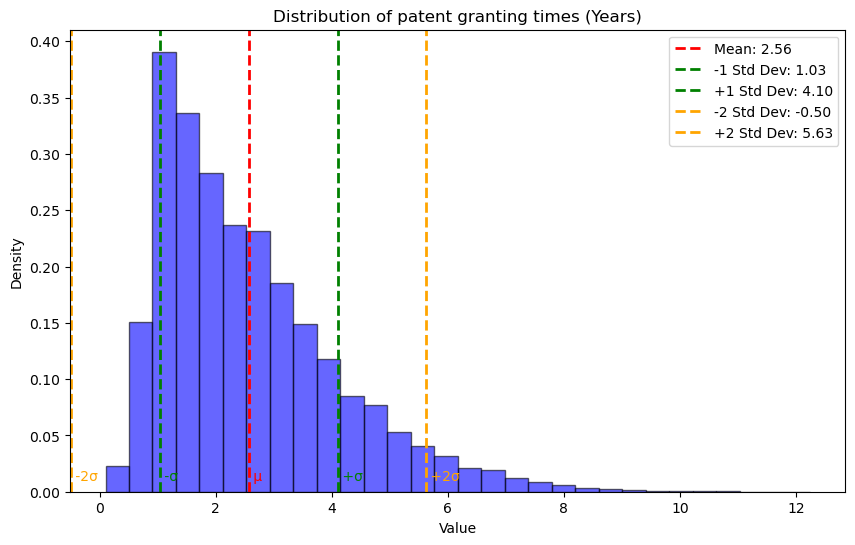

In [86]:
import numpy as np
data = pubs_with_available_search_reports_df.years_to_grant

# Calculate statistics
mean = np.mean(data)
std_dev = np.std(data)

# Define standard deviation intervals
one_std_range = (mean - std_dev, mean + std_dev)
two_std_range = (mean - 2 * std_dev, mean + 2 * std_dev)

# Count values within each range
within_one_std = np.sum((data >= one_std_range[0]) & (data <= one_std_range[1]))
within_two_std = np.sum((data >= two_std_range[0]) & (data <= two_std_range[1]))

# Create histogram
plt.figure(figsize=(10, 6))
plt.hist(data, bins=30, alpha=0.6, color='blue', edgecolor='black', density=True)

# Marking mean and standard deviations
plt.axvline(mean, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.2f}')
plt.axvline(one_std_range[0], color='green', linestyle='dashed', linewidth=2, label=f'-1 Std Dev: {one_std_range[0]:.2f}')
plt.axvline(one_std_range[1], color='green', linestyle='dashed', linewidth=2, label=f'+1 Std Dev: {one_std_range[1]:.2f}')
plt.axvline(two_std_range[0], color='orange', linestyle='dashed', linewidth=2, label=f'-2 Std Dev: {two_std_range[0]:.2f}')
plt.axvline(two_std_range[1], color='orange', linestyle='dashed', linewidth=2, label=f'+2 Std Dev: {two_std_range[1]:.2f}')

# Annotations
plt.text(mean, 0.02, " μ", verticalalignment='top', color='red')
plt.text(one_std_range[0], 0.02, " -σ", verticalalignment='top', color='green')
plt.text(one_std_range[1], 0.02, " +σ", verticalalignment='top', color='green')
plt.text(two_std_range[0], 0.02, " -2σ", verticalalignment='top', color='orange')
plt.text(two_std_range[1], 0.02, " +2σ", verticalalignment='top', color='orange')


plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Distribution of patent granting times (Years)')
plt.legend()

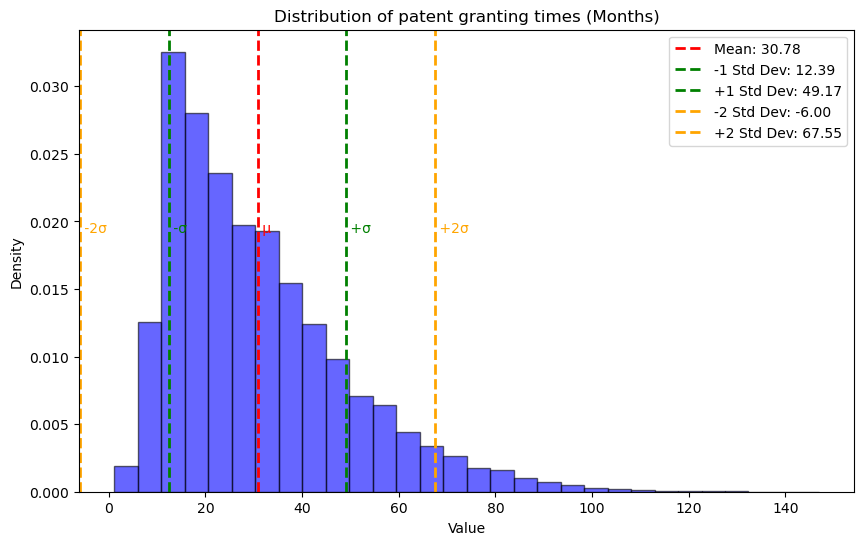

In [87]:
import numpy as np
data = pubs_with_available_search_reports_df.months_to_grant

# Calculate statistics
mean = np.mean(data)
std_dev = np.std(data)

# Define standard deviation intervals
one_std_range = (mean - std_dev, mean + std_dev)
two_std_range = (mean - 2 * std_dev, mean + 2 * std_dev)

# Count values within each range
within_one_std = np.sum((data >= one_std_range[0]) & (data <= one_std_range[1]))
within_two_std = np.sum((data >= two_std_range[0]) & (data <= two_std_range[1]))

# Create histogram
plt.figure(figsize=(10, 6))
plt.hist(data, bins=30, alpha=0.6, color='blue', edgecolor='black', density=True)

# Marking mean and standard deviations
plt.axvline(mean, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.2f}')
plt.axvline(one_std_range[0], color='green', linestyle='dashed', linewidth=2, label=f'-1 Std Dev: {one_std_range[0]:.2f}')
plt.axvline(one_std_range[1], color='green', linestyle='dashed', linewidth=2, label=f'+1 Std Dev: {one_std_range[1]:.2f}')
plt.axvline(two_std_range[0], color='orange', linestyle='dashed', linewidth=2, label=f'-2 Std Dev: {two_std_range[0]:.2f}')
plt.axvline(two_std_range[1], color='orange', linestyle='dashed', linewidth=2, label=f'+2 Std Dev: {two_std_range[1]:.2f}')

# Annotations
plt.text(mean, 0.02, " μ", verticalalignment='top', color='red')
plt.text(one_std_range[0], 0.02, " -σ", verticalalignment='top', color='green')
plt.text(one_std_range[1], 0.02, " +σ", verticalalignment='top', color='green')
plt.text(two_std_range[0], 0.02, " -2σ", verticalalignment='top', color='orange')
plt.text(two_std_range[1], 0.02, " +2σ", verticalalignment='top', color='orange')


plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Distribution of patent granting times (Months)')
plt.legend()